In [1]:
# %reset -f

import datetime
import gurobipy as gp
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import pickle
import requests
import re
import scipy as sci
import sympy as sym
import warnings

from bs4 import BeautifulSoup
from gurobipy import GRB
from matplotlib.ticker import MultipleLocator
from numpy import sqrt, exp, log, sin, cos, pi
from numba import jit

# 全局绘图样式设置

# 整体风格
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
# 字体
plt.rcParams['font.family'] = 'Times New Roman + Microsoft YaHei'
plt.rcParams['font.size'] = 13
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# 取消右侧和上方的刻度线
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# 网格设置
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.unicode_minus'] = False
# 主副刻度线
plt.rcParams['axes.linewidth'] = 1.3  # 主刻度线的粗细

plt.rcParams['xtick.major.width'] = 1.3  # x:主刻度:宽度
plt.rcParams['xtick.major.size'] = 5.3     # x:主刻度:长度
plt.rcParams['xtick.minor.width'] = 1.3  # x:副刻度:宽度
plt.rcParams['xtick.minor.size'] = 3     # x:副刻度:长度

plt.rcParams['ytick.major.width'] = 1.3  # y:主刻度:宽度
plt.rcParams['ytick.major.size'] = 5.3     # y:主刻度:长度
plt.rcParams['ytick.minor.width'] = 1.3  # y:副刻度:宽度
plt.rcParams['ytick.minor.size'] = 3     # y:副刻度:长度
# 设置使用latex
plt.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')

# %matplotlib inline
# matplotlib.use('TkAgg')


In [ ]:
df1 = pd.read_excel('年度数据V1.xlsx')
df2 = df1.loc[1:, '农、林、牧、渔业电力消费总量(亿千瓦小时)':'居民生活电力消费总量(亿千瓦小时)']
df2

In [ ]:
# Bartlett's球状检验
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
 
chi_square_value, p_value = calculate_bartlett_sphericity(df2)
print(chi_square_value, p_value)



In [ ]:
from sklearn import preprocessing
df2 = preprocessing.scale(df2)
covX = np.around(np.corrcoef(df2.T),decimals=3)
featValue, featVec=  np.linalg.eig(covX.T)  #求解系数相关矩阵的特征值和特征向量
featValue, featVec

In [ ]:
# 画碎石图
def my_zoom(x, y, ax, axin_size, xlim, ylim, loc):
    # 创建缩放图
    axins = ax.inset_axes(axin_size, transform=ax.transData)
    axins.plot(x, y, marker='*',color="#FFCA28")
    axins.set_xlim(xlim)
    axins.set_ylim(ylim)
    for key in axins.spines:
        axins.spines[key].set_visible(True)
        axins.spines[key].set_linewidth(0.8)
    axins.tick_params(axis='both', which='both', width=0.8)
    rectpatch, connects=ax.indicate_inset_zoom(axins, linestyle='--', linewidth=1.5, edgecolor='#BDBDBD', alpha=1)
    # 移除所有原来的连线
    for con in connects:
        con.set_visible(False)
    
    # 构建所有框选区域
    ax_pos = [(xlim[0], ylim[1]),(xlim[1], ylim[1]),
              (xlim[0], ylim[0]),(xlim[1], ylim[0])]
    axin_pos = [(axin_size[0], axin_size[1] + axin_size[3]),
                (axin_size[0] + axin_size[2], axin_size[1] + axin_size[3]),
                (axin_size[0], axin_size[1]),
                (axin_size[0] + axin_size[2], axin_size[1])]
    for i in range(4):
        if loc[i] == 0:
            continue
        else:
            ax.plot([ax_pos[i][0], axin_pos[loc[i]-1][0]], 
                    [ax_pos[i][1], axin_pos[loc[i]-1][1]], 
                    linewidth=1.5, linestyle='--', color='#BDBDBD')
            
    

y = featValue/np.sum(featValue)
x = np.arange(len(y)) + 1

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, y, marker='*',color="#FFCA28")
ax.set_xlim([0,52])
ax.set_ylim()
ax.set_xlabel('Factors')
ax.set_ylabel('Eigenvalue')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))

# 缩放图的位置
axin_size = [18, 0.2, 20, 0.5]
# 缩放内容区间
xlim = [0.5, 8]
ylim = [-0.02, 0.2]
loc = [0, 1, 0, 3]
# loc[0]=0：不连接
# loc[0]=3：原图框选区域的左上角坐标与axins的左下角连接
# loc[3]=1：原图框选区域的右下角坐标与axins的左上角连接
# 左上，右上，左下，右下

# 调用函数绘制连线
my_zoom(x, y, ax, axin_size, xlim, ylim, loc)

plt.savefig('碎石图.pdf',bbox_inches = 'tight',dpi=400)

In [ ]:
# 第一主成分
(featVec[:, 0].T * df2).sum(axis=1)

In [3]:
# 时间序列预测
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Load the dataset from the CSV file using pandas
df3 = pd.read_excel('月度发电量.xlsx')
df3 = df3.iloc[::-1]
df3 = df3.reset_index(drop=True)
df3['ds'] = pd.to_datetime(df3['ds'], format='%Y年%m月')

In [5]:
m = NeuralProphet(
    n_changepoints = 10,
    quantiles=[0.05, 0.95], 
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    trend_global_local="local",
    season_global_local="local", 
    ar_layers=[16, 8, 8, 16],
    collect_metrics=["MSE", "MAE", "RMSE"])
metrics = m.fit(df3)
forecast_now = m.predict(df3)
future = m.make_future_dataframe(df3, periods=12 * 37 + 1)
forecast_future = m.predict(future)
forecast_full = forecast_now.append(forecast_future)
# full_forecast.append(forecast_now.append(forecast_future))

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

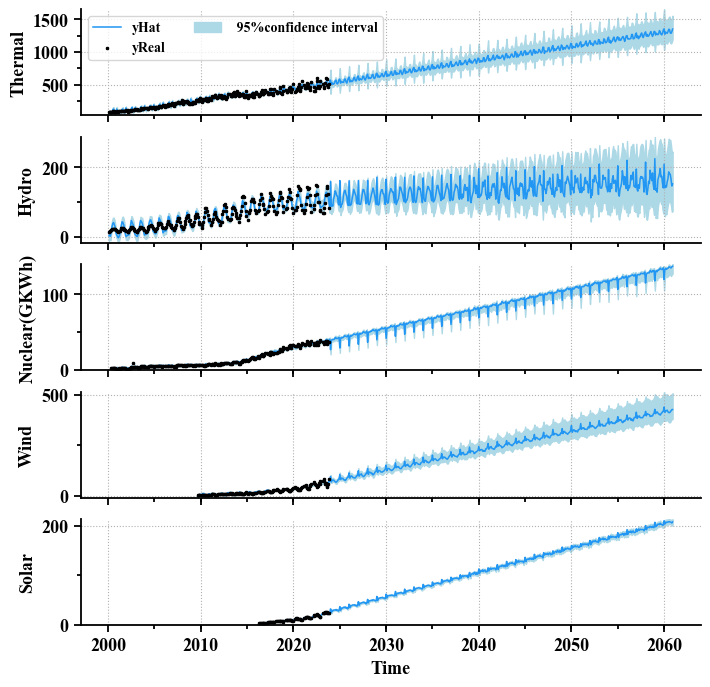

In [40]:
def draw_ts(full_forecast, ax, label):
    ax.plot(full_forecast['ds'], full_forecast['yhat1'], linewidth=1.1, label=label, color='#2196F3')
    ax.scatter(full_forecast['ds'], full_forecast['y'],color='black',marker='x',s=3,zorder=2)
    ax.fill_between(full_forecast['ds'], full_forecast['yhat1 5.0%'], full_forecast['yhat1 95.0%'], color='lightblue')
    ymin = min(full_forecast['yhat1 5.0%'].min(), full_forecast['y'].min())
    ymax = max(full_forecast['yhat1 95.0%'].max(), full_forecast['y'].max())
    ax.set_ylim(ymin, ymax)

fig, axs = plt.subplots(5, 1, figsize=(8,8), sharex=True)

col_names = ['火电','水电','核电','风电','太阳能']

forecast_full_GKWh = forecast_full.copy()
forecast_full_GKWh.loc[:,'yhat1':'season_daily'] = forecast_full_GKWh.loc[:,'yhat1':'season_daily'] / 10
forecast_full_GKWh.loc[:,'y'] = forecast_full_GKWh.loc[:,'y'] / 10
for i, col_name in enumerate(col_names):
    draw_ts(forecast_full_GKWh[forecast_full_GKWh['ID'] == col_name], axs[i], col_name)

ylims = [[-100,10000],[-100,500],[-100,1000],[-100,5000],[-100,2000]]
power_names = ['Thermal','Hydro','Nuclear(GKWh)','Wind','Solar']
for ax, power_name, ylim in zip(axs, power_names, ylims):
    ax.set_ylabel(power_name)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
axs[4].set_xlabel('Time')
axs[0].legend(['yHat','yReal',' 95%confidence interval'],loc=2,ncol=2,prop = {'size':10})

plt.savefig('Q1p.pdf',dpi=500, bbox_inches='tight')

In [52]:
def my_zoom(x, y, ax, axin_size, xlim, ylim, loc):
    # 创建缩放图
    axins = ax.inset_axes(axin_size, transform=ax.transData)
    axins.plot(x, y)
    axins.set_xlim(xlim)
    axins.set_ylim(ylim)
    for key in axins.spines:
        axins.spines[key].set_visible(True)
        axins.spines[key].set_linewidth(0.8)
    axins.tick_params(axis='both', which='both', width=0.8)
    rectpatch, connects=ax.indicate_inset_zoom(axins, linestyle='--', linewidth=1.5, edgecolor='#BDBDBD', alpha=1)
    # 移除所有原来的连线
    for con in connects:
        con.set_visible(False)
    
    # 构建所有框选区域
    ax_pos = [(xlim[0], ylim[1]),(xlim[1], ylim[1]),
              (xlim[0], ylim[0]),(xlim[1], ylim[0])]
    axin_pos = [(axin_size[0], axin_size[1] + axin_size[3]),
                (axin_size[0] + axin_size[2], axin_size[1] + axin_size[3]),
                (axin_size[0], axin_size[1]),
                (axin_size[0] + axin_size[2], axin_size[1])]
    for i in range(4):
        if loc[i] == 0:
            continue
        else:
            ax.plot([ax_pos[i][0], axin_pos[loc[i]-1][0]], 
                    [ax_pos[i][1], axin_pos[loc[i]-1][1]], 
                    linewidth=1.5, linestyle='--', color='#BDBDBD')
            
x = np.linspace(0,5,100)
y = np.sin(x)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(x, y)
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel('-Xlabel-')
ax.set_ylabel('-Ylabel-')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))

# 缩放图的位置
axin_size = [0.7, -0.8, 1.5, 1]
# 缩放内容区间
xlim = [1, 2.5]
ylim = [0.5, 1.05]
loc = [0, 0, 1, 2]
# loc[0]=0：不连接
# loc[0]=3：原图框选区域的左上角坐标与axins的左下角连接
# loc[3]=1：原图框选区域的右下角坐标与axins的左上角连接
# 左上，右上，左下，右下

# 调用函数绘制连线
my_zoom(x, y, ax, axin_size, xlim, ylim, loc)

# plt.savefig('带缩放的曲线图.svg', bbox_inches='tight')

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
            2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
            2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
            2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054,
            2055, 2056, 2057, 2058, 2059, 2060],
           dtype='int64', name='年份')

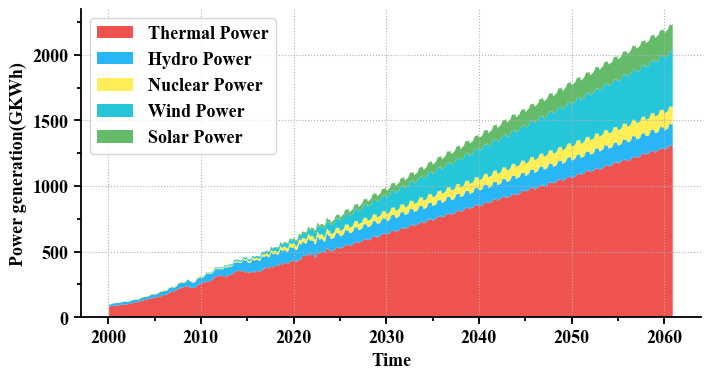

In [3]:
# 绘制堆积图
df_predict = pd.read_excel('q1真实与预测数据.xlsx',sheet_name='Sheet1')
colors = ['#EF5350','#29B6F6','#FFEE58','#26C6DA','#66BB6A']
col_names = ['火电','水电','核电','风电','太阳能']
df_predict['时间'] = pd.to_datetime(df_predict['时间'], format='%Y-%m-%d')
df_predict_GKWh = df_predict.copy()
df_predict_GKWh.loc[:,col_names] = df_predict_GKWh.loc[:,col_names] / 10
alpha = 0.2  # 指数加权移动平均的平滑参数
df_predict_GKWh['火电'] = df_predict_GKWh['火电'].ewm(alpha=alpha, adjust=False).mean()
df_predict_GKWh['水电'] = df_predict_GKWh['水电'].ewm(alpha=alpha, adjust=False).mean()
df_predict_GKWh['核电'] = df_predict_GKWh['核电'].ewm(alpha=alpha, adjust=False).mean()
df_predict_GKWh['风电'] = df_predict_GKWh['风电'].ewm(alpha=alpha, adjust=False).mean()
df_predict_GKWh['太阳能'] = df_predict_GKWh['太阳能'].ewm(alpha=alpha, adjust=False).mean()
# 绘制堆积图
fig, ax = plt.subplots(figsize=(8,4))
ax.stackplot(df_predict_GKWh['时间'], df_predict_GKWh['火电'], df_predict_GKWh['水电'], df_predict_GKWh['核电'], df_predict_GKWh['风电'], df_predict_GKWh['太阳能'], colors=colors)
ax.set_xlabel('Time')
ax.set_ylabel('Power generation(GKWh)')
ax.legend(['Thermal Power','Hydro Power','Nuclear Power','Wind Power','Solar Power'],loc='upper left')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
plt.savefig('能源比例.pdf', bbox_inches='tight')

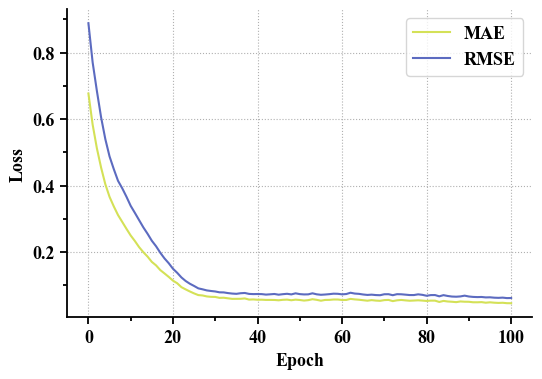

In [18]:
# 绘制训练收敛图
MAE = m.trainer.logger.history['MAE'][:101]
RMSE = m.trainer.logger.history['RMSE'][:101]
epoch = m.trainer.logger.history['epoch'][:101]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epoch, MAE,color='#D4E157')
ax.plot(epoch, RMSE,color='#5C6BC0')
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['MAE','RMSE'])
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(n=2))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n=2))

plt.savefig('损失函数.pdf', bbox_inches='tight')